In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

Importing dataset(https://zenodo.org/record/1327317#.Y91rRHbMLDc) from my drive

In [ ]:
data_path = "/content/drive/MyDrive/Datasets/Ultrasound_fetal"
import zipfile
from PIL import Image

# Open the zip file
#ultra sound images of fetal head
with zipfile.ZipFile(data_path+"/test_set.zip", "r") as zip_ref:
    # Extract the image file
    zip_ref.extractall("")

# Open the zip file
# target images of ellipses around the fetal head
with zipfile.ZipFile(data_path+"/training_set.zip", "r") as zip_ref:
    # Extract the image file
    zip_ref.extractall("")

# Open the zip file
# training annotations was created using the convex_hull_preprocess function in the cell below to fill the ellipses
with zipfile.ZipFile(data_path+"/training_annotations.zip", "r") as zip_ref:
    # Extract the image file
    zip_ref.extractall("")

In [ ]:
#dont need to run anymore
from skimage.morphology import convex_hull_image
from PIL import Image
import os
from tqdm import tqdm
import glob

def convex_hull(image_path):
    #convex hull will fill ellipses in the image
    image = Image.open(image_path)
    image = np.array(image)
    chull_image = convex_hull_image(image)
    return chull_image

def convex_hull_preprocess():
    # go over all files
    os.mkdir("/content/training_annotations/") 
    paths = os.listdir("/content/training_set")
    for path in tqdm(paths):
        if path[-14:]=='Annotation.png':
            im = convex_hull("/content/training_set/"+path)
            im = Image.fromarray(im)
            im.save("/content/training_annotations/"+path)
convex_hull_preprocess()

In [ ]:
import tensorflow as tf
from skimage.morphology import convex_hull_image

def load_image(image_path):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image
    image = tf.image.decode_png(image)
    image = tf.image.resize(image, [540, 800])

    # Normalize the pixel values
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

def process_annotation(image,annotation):
    #if need to preprocess annotations, for now no preprocessing
    return annotation


def crop_resize(image):
    # image of shape (540, 800, 1)
    # crop image borders that contain some ultra sound artefacts
    cropped_image = image[20:520,25:775,:]
    cropped_image = tf.math.divide(cropped_image, 255)
    cropped_image = tf.image.resize(cropped_image,(128,128))
    return cropped_image

def crop_resize_data(image,annotation):
    cropped_image       = crop_resize(image)
    cropped_annotation  = crop_resize(annotation)
    cropped_annotation  = process_annotation(cropped_image,cropped_annotation)

    return (cropped_image,cropped_annotation)

def get_dataset(test=False):
    # get file names
    if not test:
        image_paths = tf.data.Dataset.list_files("training_set/*HC.png",shuffle=False)
        annotation_paths = tf.data.Dataset.list_files("training_annotations/*Annotation.png",shuffle=False)
    else:
        image_paths = tf.data.Dataset.list_files("test_set/*HC.png")

    #load the images
    images      = image_paths.map(load_image)
    annotations = annotation_paths.map(load_image)
    # prefetch for performance
    images = images.prefetch(tf.data.AUTOTUNE)
    annotations = annotations.prefetch(tf.data.AUTOTUNE)

    BATCH_SIZE = 16
    if test:
        data = images
        data = data.map(crop_resize)
        data = data.batch(batch_size=BATCH_SIZE)
        return data
    else:
        data = tf.data.Dataset.zip((images, annotations))
        data = data.map(crop_resize_data)
        data = data.batch(batch_size=BATCH_SIZE)
        return data

In [ ]:
train_data = get_dataset()

In [ ]:
iterator = iter(train_data)
X,y = next(iterator)

In [ ]:
X.shape,y.shape

(TensorShape([16, 128, 128, 1]), TensorShape([16, 128, 128, 1]))

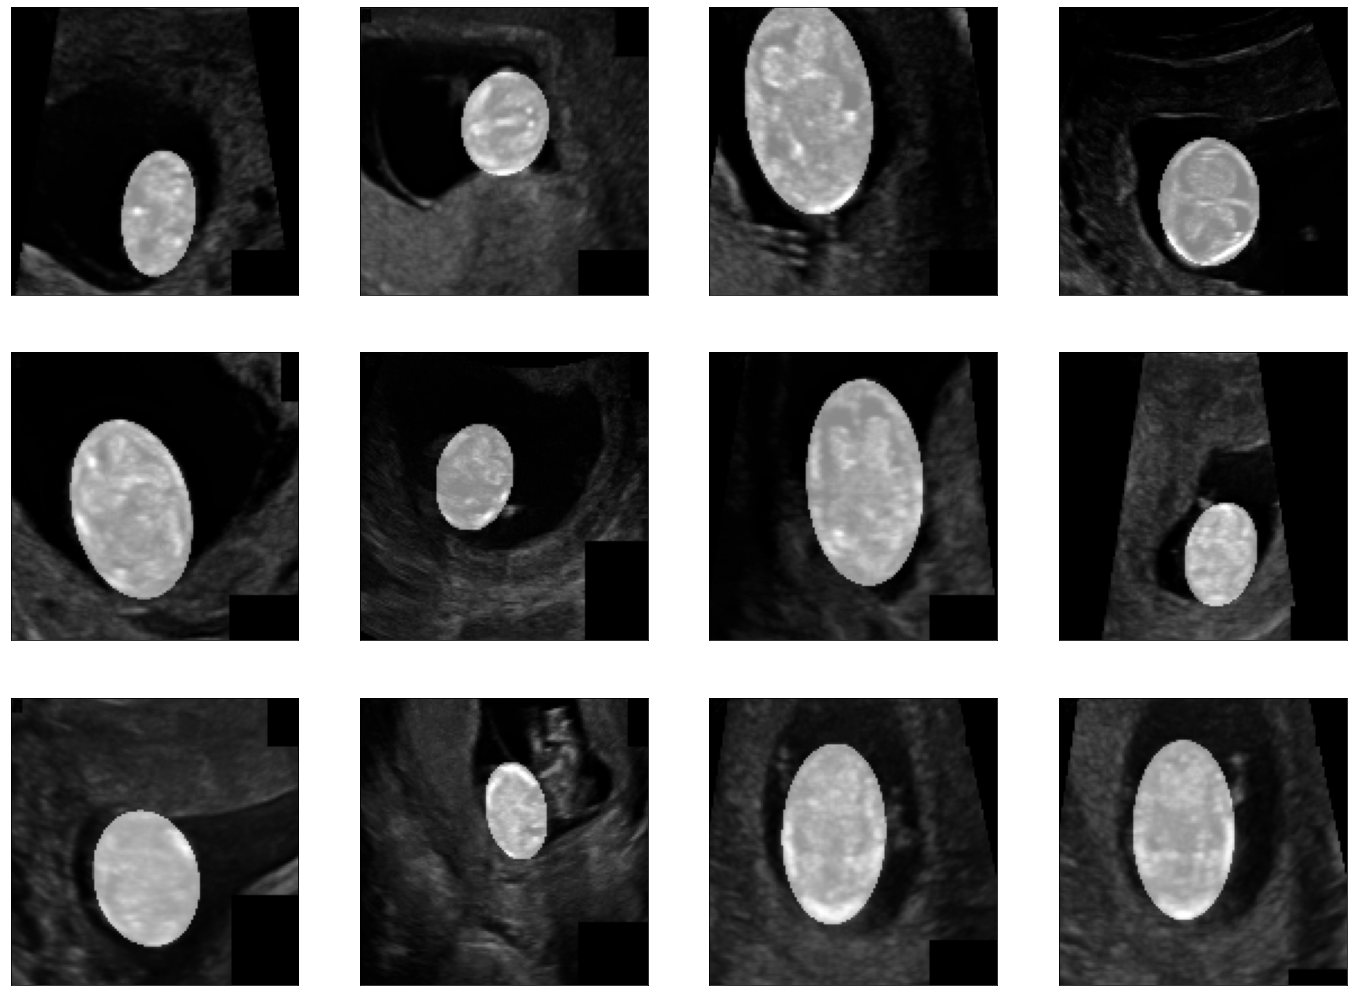

In [ ]:
#looking at the data + targets
fig,axs = plt.subplots(3,4,figsize=(24,18))
i = 0
for ax in axs.flatten():
    ax.imshow(X[i][:,:,0]+y[i][:,:,0],cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1

# Unet model for image segmentation

In [ ]:
#Define dice loss
def dice_coef(y_true, y_pred):        
    num = 2*tf.reduce_sum(tf.math.multiply(y_true,y_pred))
    den = tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)
    return 1-num/den

def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   x = tf.keras.layers.Dense(64,activation='relu')(x)
   x = tf.keras.layers.Dense(64,activation='relu')(x)
   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = tf.keras.layers.MaxPool2D(2)(f)
   p = tf.keras.layers.Dropout(0.2)(p)

   return f, p
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = tf.keras.layers.concatenate([x, conv_features])
   # dropout
   x = tf.keras.layers.Dropout(0.2)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x
def build_unet_model():
 # inputs
   inputs = tf.keras.layers.Input(shape=(128,128,1))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 16)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 32)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 64)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 64)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 32)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 64)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 64)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 64)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model


In [ ]:
unet = build_unet_model()
# Compile the model
callback = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0.005,
    patience=10,
)
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

unet.compile(optimizer=opt, loss=dice_coef,metrics=METRICS)
unet.summary()
unet.fit(train_data,epochs=50)

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_171 (Conv2D)            (None, 128, 128, 16  160         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 dense_138 (Dense)              (None, 128, 128, 64  1088        ['conv2d_171[0][0]']             
                                )                                                             

In [ ]:
import tensorflow as tf


# Define a naif model
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(128, 128, 1)),
    tf.keras.layers.Conv2D(32, (32,32), activation='relu'),
    tf.keras.layers.Conv2D(32, (32,32), activation='relu'),
    tf.keras.layers.Conv2D(16, (16,16), activation='relu'),
    tf.keras.layers.Conv2D(16, (16,16), activation='relu'),
    tf.keras.layers.Conv2D(8, (8,8), activation='relu'),
    tf.keras.layers.Conv2D(8, (8,8), activation='relu'),
    tf.keras.layers.Conv2D(4, (4,4), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(128*128,activation='sigmoid'),
    tf.keras.layers.Reshape((128,128,1))
],name="annotatron")

# Compile the model
callback = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0.01,
    patience=5,
)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=METRICS)
model.summary()

Model: "annotatron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Batc  (None, 128, 128, 1)      4         
 hNormalization)                                                 
                                                                 
 conv2d_50 (Conv2D)          (None, 97, 97, 32)        32800     
                                                                 
 conv2d_51 (Conv2D)          (None, 66, 66, 32)        1048608   
                                                                 
 conv2d_52 (Conv2D)          (None, 51, 51, 16)        131088    
                                                                 
 conv2d_53 (Conv2D)          (None, 36, 36, 16)        65552     
                                                                 
 conv2d_54 (Conv2D)          (None, 29, 29, 8)         8200      
                                                        

In [ ]:
model.fit(train_data,epochs=50,callbacks=[callback])

Epoch 1/50
63/63 [==============================] - 8s 125ms/step - loss: 0.2676 - accuracy: 0.8841 - precision: 0.8437 - recall: 0.8313
Epoch 2/50
63/63 [==============================] - 6s 98ms/step - loss: 0.2642 - accuracy: 0.8854 - precision: 0.8372 - recall: 0.8455
Epoch 3/50
63/63 [==============================] - 8s 122ms/step - loss: 0.2587 - accuracy: 0.8861 - precision: 0.8386 - recall: 0.8459
Epoch 4/50
63/63 [==============================] - 6s 97ms/step - loss: 0.2493 - accuracy: 0.8893 - precision: 0.8439 - recall: 0.8493
Epoch 5/50
63/63 [==============================] - 7s 115ms/step - loss: 0.2370 - accuracy: 0.8949 - precision: 0.8515 - recall: 0.8573
Epoch 6/50
63/63 [==============================] - 8s 126ms/step - loss: 0.2215 - accuracy: 0.9011 - precision: 0.8585 - recall: 0.8688
Epoch 7/50
63/63 [==============================] - 6s 96ms/step - loss: 0.2122 - accuracy: 0.9041 - precision: 0.8603 - recall: 0.8764
Epoch 8/50
63/63 [==========================

In [ ]:
# unet = tf.keras.models.load_model("/content/drive/MyDrive/Datasets/Ultrasound_fetal/unet_with_dice_coef.h5",custom_objects={'dice_coef':dice_coef})

# looking at results of Unet model train set

1/1 [==============================] - 0s 53ms/step


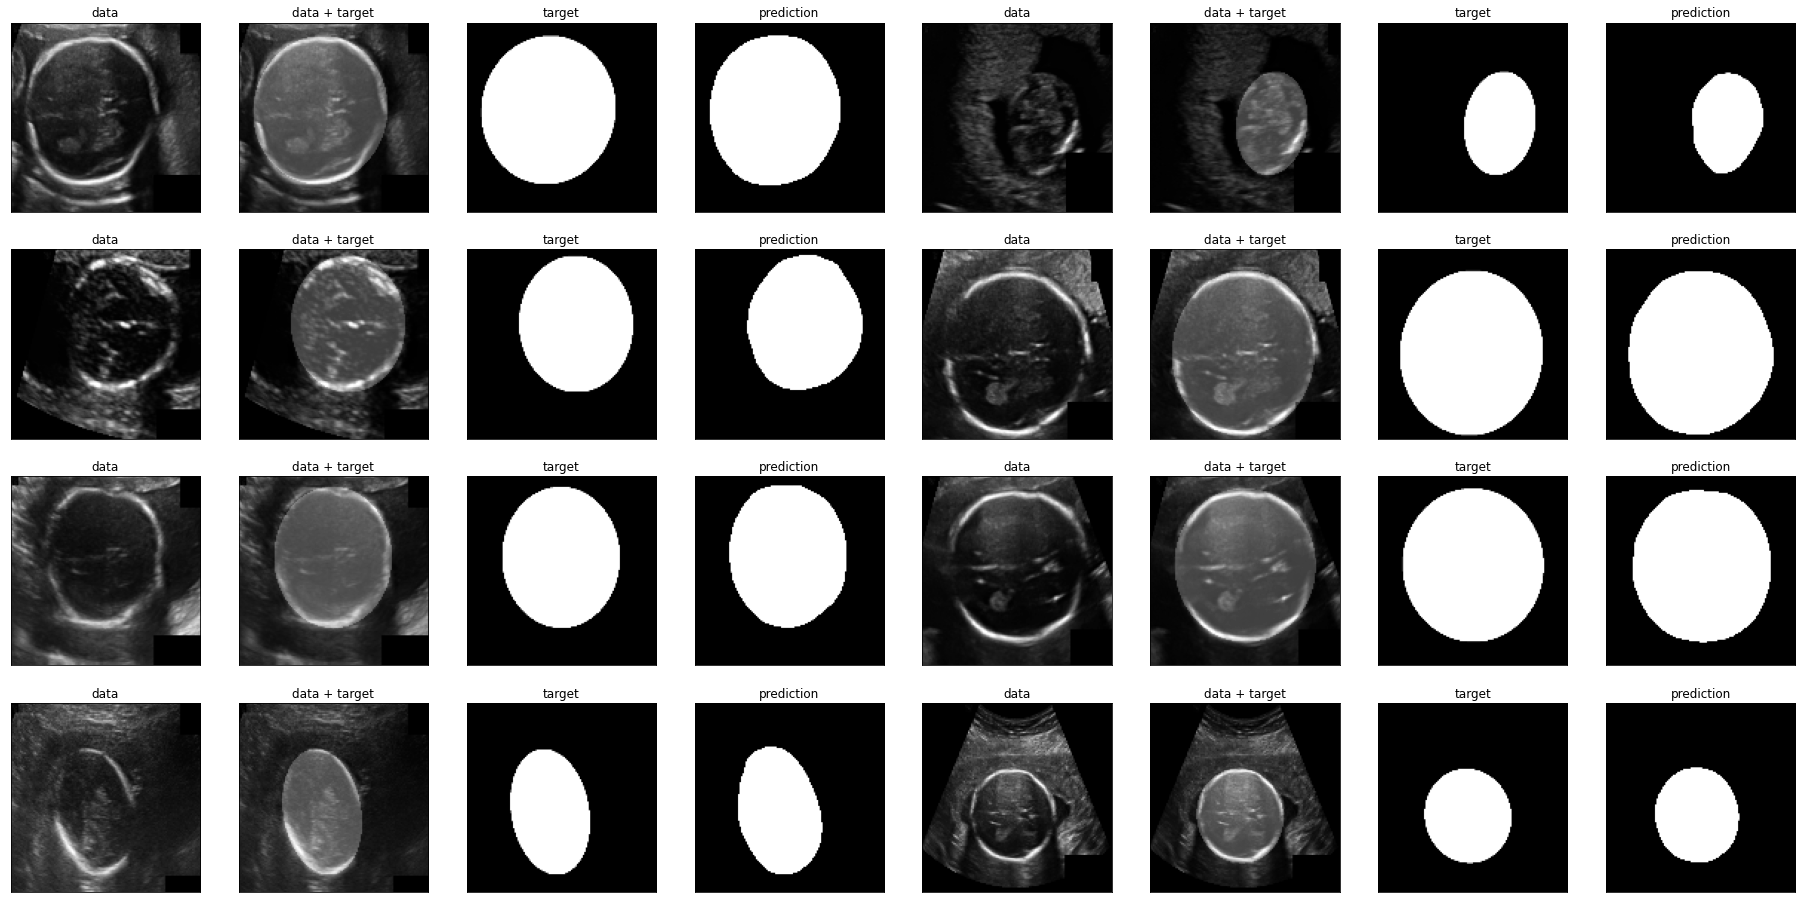

In [ ]:
index = [f"{np.random.randint(0,405):03d}" for _ in range(8)]
to_plot = []
for i in index:
    img = tf.io.read_file(f"/content/training_set/{i}_HC.png")
    img = tf.image.decode_png(img)

    target = tf.io.read_file(f"/content/training_annotations/{i}_HC_Annotation.png")
    target = tf.image.decode_png(target)

    X = crop_resize(img)
    target = crop_resize(target)

    X=tf.expand_dims(X,0)
    y = unet.predict(X)

    to_plot.append([X[0,:,:,0],X[0,:,:,0]+0.3*target[:,:,0],target[:,:,0],y[0,:,:,0]])

to_plot = np.array(to_plot)
col_repeat_factor = 2
to_plot = to_plot.reshape((len(index)//col_repeat_factor,col_repeat_factor*4,128,128))


cols = to_plot.shape[1]
rows = to_plot.shape[0]
fig,axs = plt.subplots(rows,cols,figsize=(4*cols,4*rows))

label_titles = {0:'data',1:'data + target',2:'target', 3:'prediction'}
for i in range(rows):
    for j in range(cols):
        axs[i,j].imshow(to_plot[i][j],cmap="gray")
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].set_title(label_titles[j%4])

#Results on test set

1/1 [==============================] - 0s 29ms/step


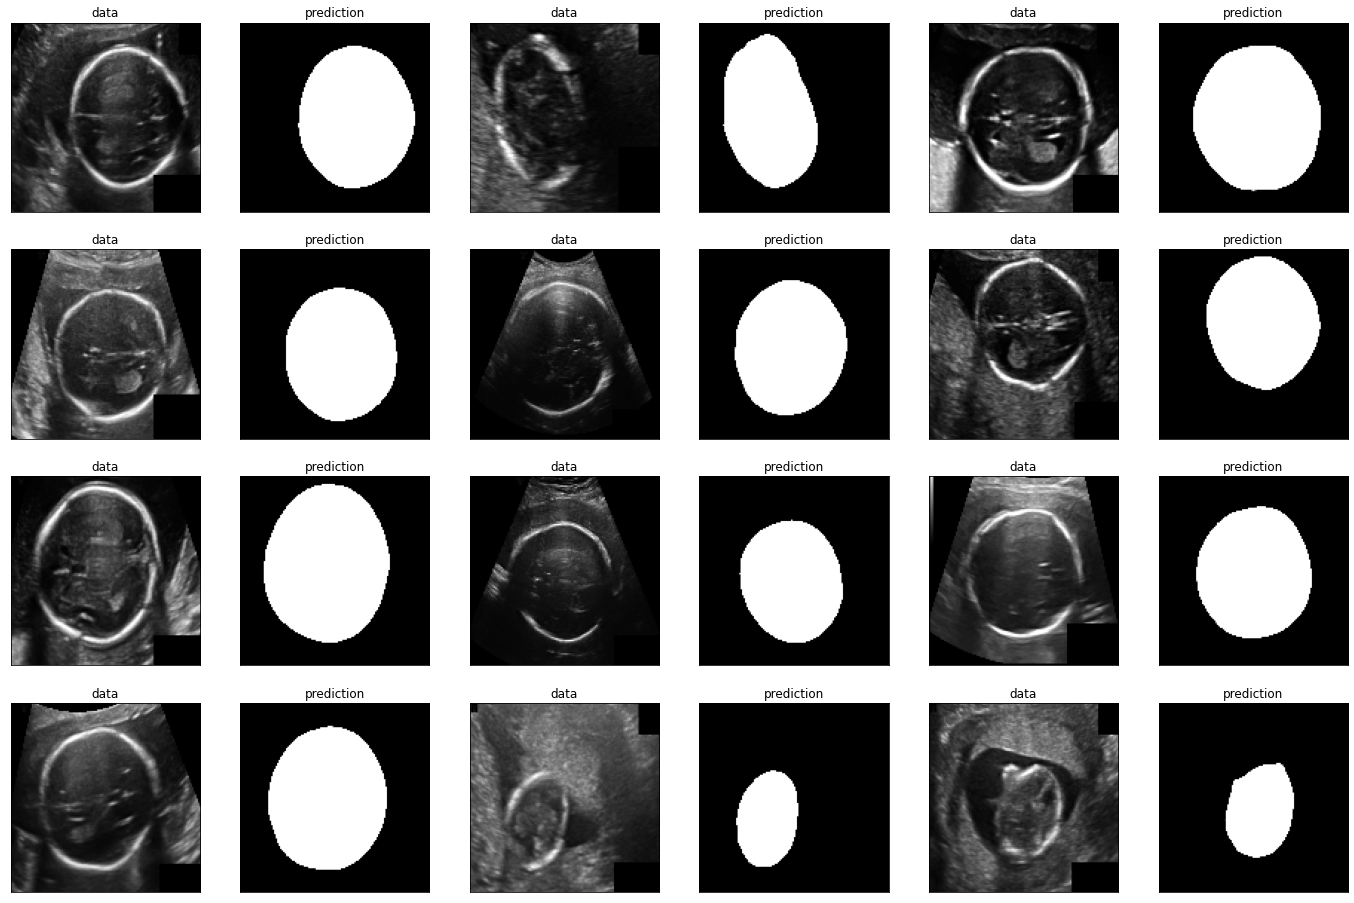

In [ ]:
index = [f"{np.random.randint(0,335):03d}" for _ in range(12)]
to_plot = []
for i in index:
    img = tf.io.read_file(f"/content/test_set/{i}_HC.png")
    img = tf.image.decode_png(img)

    X = crop_resize(img)
    target = crop_resize(target)

    X=tf.expand_dims(X,0)
    y = unet.predict(X)

    to_plot.append([X[0,:,:,0],y[0,:,:,0]])

to_plot = np.array(to_plot)
col_repeat_factor = 3
to_plot = to_plot.reshape((len(index)//col_repeat_factor,col_repeat_factor*2,128,128))


cols = to_plot.shape[1]
rows = to_plot.shape[0]
fig,axs = plt.subplots(rows,cols,figsize=(4*cols,4*rows))

label_titles = {0:'data', 1:'prediction'}
for i in range(rows):
    for j in range(cols):
        axs[i,j].imshow(to_plot[i][j],cmap="gray")
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].set_title(label_titles[j%2])

In [ ]:
unet.save('/content/drive/MyDrive/Datasets/Ultrasound_fetal/unet_with_dice_coef.h5')